In [1]:
import json
import re
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from matplotlib.ticker import MaxNLocator

In [2]:
with open('data/speeches_20_with_comments.jsonl', 'r', encoding = 'utf8') as fp:#Falls eine andere Regierungperiode analysiert werden soll, hier anderen Datensatz einfügen, des weiteren muss weiter unten die Definition von Regierung und Oppossition angepasst werden
    data = list(fp)
speeches = []
for line in data:
    speeches.append(json.loads(line))

In [3]:
#list of dictionaries erstellen mit rednern, parteien,...
nodes = {}
for redner in speeches:
    name = redner["name"]
    # If the speaker is already in the dictionary, increment the count
    if name in nodes:
        nodes[name]["speech_count"] += 1
        # Otherwise, add the speaker to the dictionary with speech count 1
    else:
        nodes[name] = {
            "name": redner["name"],
            "party": redner["party"],
            "speech_count": 1,
            "Regierung/Opposition": "unk" if redner["party"] == "unknown" else "Regierung" if redner["party"] == "FDP" or redner["party"] == "BÜNDNIS 90/DIE GRÜNEN" or redner["party"] == "SPD" else "Opposition"#Wenn eine andere Regierungsperiode analysiert werden soll, muss hier die Definition von Regierung und Opposition angepasst werden
        }


# Convert the unique speakers back to a list of dictionaries
nodelist = list(nodes.values())



print(nodelist)

len(nodes)

[{'name': 'Lisa Paus', 'party': 'BÜNDNIS 90/DIE GRÜNEN', 'speech_count': 133, 'Regierung/Opposition': 'Regierung'}, {'name': 'Annalena Baerbock', 'party': 'BÜNDNIS 90/DIE GRÜNEN', 'speech_count': 136, 'Regierung/Opposition': 'Regierung'}, {'name': 'Johann David Wadephul', 'party': 'CDU/CSU', 'speech_count': 56, 'Regierung/Opposition': 'Opposition'}, {'name': 'Jürgen Hardt', 'party': 'CDU/CSU', 'speech_count': 64, 'Regierung/Opposition': 'Opposition'}, {'name': 'Mario Czaja', 'party': 'CDU/CSU', 'speech_count': 13, 'Regierung/Opposition': 'Opposition'}, {'name': 'Johannes Huber', 'party': 'Fraktionslos', 'speech_count': 21, 'Regierung/Opposition': 'Opposition'}, {'name': 'Jürgen Trittin', 'party': 'BÜNDNIS 90/DIE GRÜNEN', 'speech_count': 48, 'Regierung/Opposition': 'Regierung'}, {'name': 'Stefan Keuter', 'party': 'AfD', 'speech_count': 29, 'Regierung/Opposition': 'Opposition'}, {'name': 'Karamba Diaby', 'party': 'SPD', 'speech_count': 31, 'Regierung/Opposition': 'Regierung'}, {'name': '

780

In [4]:
#Liste für Matrix erstellen
uniquenames = [d["name"] for d in nodelist]
print(uniquenames)
len(uniquenames)

['Lisa Paus', 'Annalena Baerbock', 'Johann David Wadephul', 'Jürgen Hardt', 'Mario Czaja', 'Johannes Huber', 'Jürgen Trittin', 'Stefan Keuter', 'Karamba Diaby', 'Thomas Erndl', 'Martin Reichardt', 'Jürgen Braun', 'Agnieszka Brugger', 'Ulrich Lechte', 'Clara Bünger', 'Martin Sichert', 'Anikó Glogowski-Merten', 'Annette Widmann-Mauz', 'Tilman Kuban', 'Gökay Akbulut', 'Ann-Veruschka Jurisch', 'Lisa Badum', 'Andreas Jung', 'Nina Scheer', 'Karsten Hilse', 'Olaf In der Beek', 'Ralph Lenkert', 'Timon Gremmels', 'Thomas Gebhart', 'Stefan Seidler', 'Kathrin Henneberger', 'Lukas Köhler', 'Andreas Lenz', 'Robin Mesarosch', 'Christian Lindner', 'Alexander Dobrindt', 'Christine Lambrecht', 'Peter Boehringer', 'Amira Mohamed Ali', 'Marco Buschmann', 'Karsten Klein', 'Mathias Middelberg', 'Achim Post', 'Michael Espendiller', 'Sven-Christian Kindler', 'Britta Haßelmann', 'Otto Fricke', 'Wolfgang Hellmich', 'Andreas Schwarz', 'Volker Redder', 'Johannes Steiniger', 'Nadine Heselhaus', 'Jörn König', 'Sab

780

In [5]:
#Erstellen der Matrix
#
#Namen werden innerhalb von Reden nur einmal gezählt->mehrere Zwischenrufe von der selben Person in derselben Rede werden nicht berücksichtigt

n = len(uniquenames)
matrix = np.zeros((n, n), dtype=int)

# Create a mapping from name to index
name_to_index = {name: i for i, name in enumerate(uniquenames)}

#
Kommentar = r"\{\(.*?\)\}"

# Populate the matrix
for speech in speeches:
    speaker_name = speech["name"]
    speaker_index = name_to_index[speaker_name]


    Kommentarcontent = re.findall(Kommentar, speech["text"])

    # Join all text found inside curly brackets into a single string for easier name search
    inside_text = " ".join(Kommentarcontent)

    for name in uniquenames:
        if name != speaker_name:  # Avoid counting the speaker's own name

            if name in inside_text:
                target_index = name_to_index[name]
                matrix[speaker_index][target_index] += 1
                # Break the loop or conditionally skip if already counted in this speech


In [15]:
#Matrix transponieren für intuitivere Interpretierbarkeit
#Nach transponieren bedeutet ein "Pfeil" von A zu B, dass A bei B einen Zwischenruf getätigt hat
TransponierteMatrix = matrix.T
TMatrix = TransponierteMatrix.tolist()

                  Speaker  Weighted Out-Degree
196      Stephan Brandner                 1438
370         Götz Frömming                  988
650  Matthias W. Birkwald                  764
540         Thorsten Frei                  702
282     Marianne Schieder                  539
125            Jens Spahn                  536
632     Patrick Schnieder                  491
240          Rainer Kraft                  479
78         Julia Klöckner                  478
24          Karsten Hilse                  440


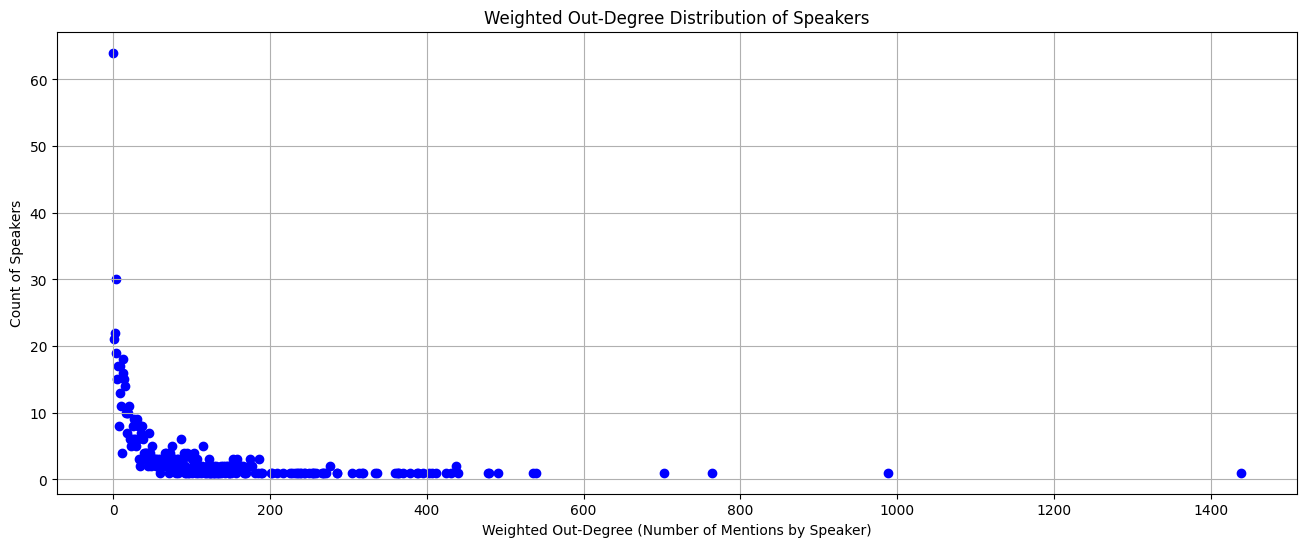

In [16]:
#Verteilung der gewichteten Ausgangsgrade
#Gewichteter Ausgangsgrad einer Person: Anzahl an Reden bei der die Person mindestens einen Zwischenruf getätigt hat
#Ausgangsgrad einer Person: Anzahl an Rednern bei denen die Person mindestens einen Zwischenruf getätigt hat

# Calculate the weighted out-degree for each speaker (sum of rows in the matrix)
wout_degrees = np.sum(TMatrix, axis=1)

# Count the occurrences of each out-degree
degree_distribution = Counter(wout_degrees)

# Sort the distribution by out-degree for the plot
sorted_degrees = sorted(degree_distribution.items())

# Unpack the degrees and counts for plotting
wout_degree_values, counts = zip(*sorted_degrees)

# Create the dot plot
plt.figure(figsize=(16, 6))
plt.scatter(wout_degree_values, counts, color="blue")
#plt.xscale('log')  # Set x-axis to logarithmic scale
plt.title('Weighted Out-Degree Distribution of Speakers')
plt.xlabel('Weighted Out-Degree (Number of Mentions by Speaker)')
plt.ylabel('Count of Speakers')
plt.grid(True)

# Create a table with speakers and their respective out-degrees
speaker_out_degrees = pd.DataFrame({
    'Speaker': uniquenames,
    'Weighted Out-Degree': wout_degrees
})
speaker_out_degrees_sorted = speaker_out_degrees.sort_values(by='Weighted Out-Degree', ascending=False)
# Display the table

top_10_values = speaker_out_degrees_sorted.nlargest(10, "Weighted Out-Degree")
print(top_10_values)

plt.show()

                 Redner  Weighted Out-Degree
42    Marianne Schieder                  539
204      Timon Gremmels                  395
41   Gabriele Katzmarek                  362
17     Johannes Fechner                  334
102      Leni Breymaier                  226
185  Sebastian Hartmann                  173
180     Michael Schrodi                  168
135    Johannes Schraps                  163
129    Bettina Hagedorn                  160
13       Maja Wallstein                  158


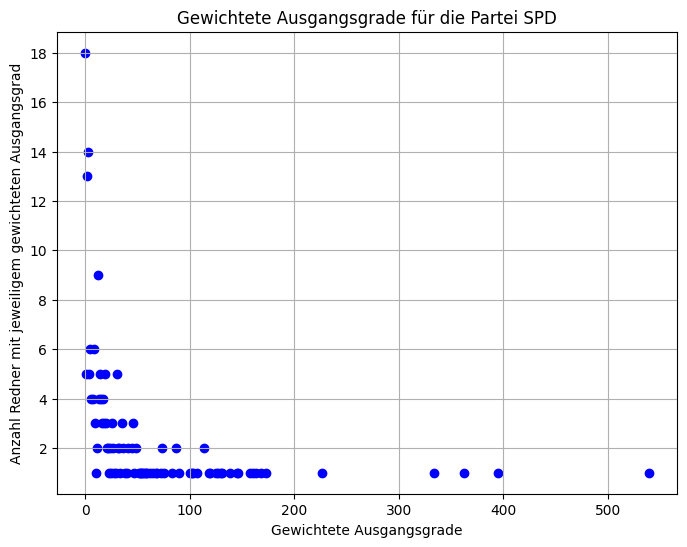

In [17]:
#Selbe Analyse nur für einzelne Parteien
ParteifürGraph = "SPD"
#BÜNDNIS 90/DIE GRÜNEN
#DIE LINKE
#CDU/CSU
#Fraktionslos
#SPD
#FDP
#AfD


party_speakers = list({speech["name"] for speech in speeches if speech["party"] == ParteifürGraph})

party_indices = [name_to_index[speaker] for speaker in party_speakers]#indices von den Rednern der Partei

woutdegrees = np.sum(TMatrix, axis=1)#alle gewichteten Outdegrees

party_woutdegrees = woutdegrees[party_indices]#nur die gewichteten Outdegrees der Partei

degree_distributionparty = Counter(party_woutdegrees)#zähle Häufigkeit der gewichteten Outdegrees

sorted_degreeparty = sorted(degree_distributionparty.items())#sortieren

woutdegreevalues, counts = zip(*sorted_degreeparty)

# Create the dot plot
plt.figure(figsize=(8, 6))
plt.scatter(woutdegreevalues, counts, color='blue')
#plt.xscale('log')  # Set x-axis to logarithmic scale
plt.title(f'Gewichtete Ausgangsgrade für die Partei {ParteifürGraph}')
plt.xlabel('Gewichtete Ausgangsgrade')
plt.ylabel('Anzahl Redner mit jeweiligem gewichteten Ausgangsgrad')
# Set the y-axis to show only integer ticks
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)


# Create a table with speakers and their respective out-degrees
speaker_out_degrees = pd.DataFrame({
    'Redner': party_speakers,
    'Weighted Out-Degree': party_woutdegrees
})
speaker_out_degrees_sorted = speaker_out_degrees.sort_values(by='Weighted Out-Degree', ascending=False)
# Display the table

top_10_values = speaker_out_degrees_sorted.nlargest(10, "Weighted Out-Degree")
print(top_10_values)

plt.show()

In [18]:
#Gephi Graph erstellen
matrixname = TMatrix
Knoten = nodelist
G = nx.DiGraph()


# Add nodes with attributes (name, age, affiliation)
for speaker in Knoten:
    G.add_node(speaker["name"], **speaker)

# Add edges based on the matrix
for i, speaker in enumerate(Knoten):
    for j, target_speaker in enumerate(Knoten):
        if matrixname[i][j] > 0:  # Only add an edge if there's a mention
            G.add_edge(speaker["name"], target_speaker["name"], weight=matrixname[i][j])

# Export the graph to GEXF format
nx.write_gexf(G, "Zwischenrufe.gexf")

print("GEXF file created")

GEXF file created


In [19]:
#Liste der Parteien erstellen
allparties = [d["party"] for d in nodelist]
uniqueparties = list(set(allparties))
uniqueparties.sort()

In [20]:
#Matrix auf Parteienebene
# Create a party-to-party mention matrix (size len(parties) x len(parties))
party_mention_matrix = np.zeros((len(uniqueparties), len(uniqueparties)), dtype=int)#row,column

# Create mappings for names to party and party to index
name_to_party = {node["name"]: node["party"] for node in nodelist}
party_to_index = {party: i for i, party in enumerate(uniqueparties)}

# Regular expression to match content inside curly brackets
curly_brackets_pattern = r"\{\(.*?\)\}"

# Populate the party-to-party mention matrix
for speech in speeches:
    speaker_name = speech["name"]
    speaker_party = name_to_party[speaker_name]

    # Find all text inside curly brackets in the speech
    inside_curly_brackets = re.findall(curly_brackets_pattern, speech["text"])

    # Join all text found inside curly brackets into a single string for easier name search
    inside_text = " ".join(inside_curly_brackets)

    # Check mentions inside curly brackets
    for mentioned_name in name_to_party.keys():
        if mentioned_name != speaker_name and mentioned_name in inside_text:
            mentioned_party = name_to_party[mentioned_name]
            # Increment the party-to-party mention count
            speaker_index = party_to_index[speaker_party]
            mentioned_index = party_to_index[mentioned_party]
            party_mention_matrix[speaker_index][mentioned_index] += 1

# Print the matrix and parties
print("Parties:", uniqueparties)
print("Party-to-party mention matrix:")
print(party_mention_matrix)
#Interpretation (zB Grüne/Union): Politiker von den Grünen haben in 3852 Reden von der Union kommentiert, Politiker der Union haben in 3281 Reden der Union kommentiert

Parties: ['AfD', 'BÜNDNIS 90/DIE GRÜNEN', 'CDU/CSU', 'DIE LINKE', 'FDP', 'Fraktionslos', 'SPD', 'unknown']
Party-to-party mention matrix:
[[ 824 2033  759  383  776   29 1960   56]
 [2042  714 3281  526  867    5  698   49]
 [1839 3852 2305  717 2047   25 3354   75]
 [ 610  553  734  379  536    4  466    5]
 [1247  756 2457  522  438    4  622   26]
 [  21   16   25   14   22    2   20    1]
 [2816 1312 4481  810 1353   11  898   51]
 [ 225  140  356   54  107    2  100   12]]


In [21]:
#unknown und fraktionslos entfernen
unk_index = party_to_index["unknown"]
Fraktionslos_index = party_to_index["Fraktionslos"]

party_mention_matrix1 = np.delete(party_mention_matrix, unk_index, axis=0)  
party_mention_matrix2 = np.delete(party_mention_matrix1, unk_index, axis=1)  
party_mention_matrix3 = np.delete(party_mention_matrix2, Fraktionslos_index, axis=0)  
party_mention_matrix4 = np.delete(party_mention_matrix3, Fraktionslos_index, axis=1)  




uniqueparties2 = [entry for entry in uniqueparties if entry != "unknown" and entry != "Fraktionslos"]

# Print the updated matrix
print("Updated Matrix:")
print(party_mention_matrix4)
print(uniqueparties2)

# Convert the matrix to a pandas DataFrame and set row/column labels with new_names
#dfparty = pd.DataFrame(party_mention_matrix4, index=uniqueparties2, columns=uniqueparties2)

# Export the DataFrame to an Excel file
#output_file = 'Parteien.xlsx'
#dfparty.to_excel(output_file)

Updated Matrix:
[[ 824 2033  759  383  776 1960]
 [2042  714 3281  526  867  698]
 [1839 3852 2305  717 2047 3354]
 [ 610  553  734  379  536  466]
 [1247  756 2457  522  438  622]
 [2816 1312 4481  810 1353  898]]
['AfD', 'BÜNDNIS 90/DIE GRÜNEN', 'CDU/CSU', 'DIE LINKE', 'FDP', 'SPD']


In [22]:
#Anzahl Kommentare pro Partei
Kommentarepropartei = np.sum(party_mention_matrix, axis=0)#Summe über Spalten, axis=1 würde anzeigen wie viele Kommentare es in Reden von der Partei gab

# Print the results
for i, party in enumerate(uniqueparties):
    print(f"{party}: Kommentare in {Kommentarepropartei[i]} Reden von anderen Parteien")

AfD: Kommentare in 9624 Reden von anderen Parteien
BÜNDNIS 90/DIE GRÜNEN: Kommentare in 9376 Reden von anderen Parteien
CDU/CSU: Kommentare in 14398 Reden von anderen Parteien
DIE LINKE: Kommentare in 3405 Reden von anderen Parteien
FDP: Kommentare in 6146 Reden von anderen Parteien
Fraktionslos: Kommentare in 82 Reden von anderen Parteien
SPD: Kommentare in 8118 Reden von anderen Parteien
unknown: Kommentare in 275 Reden von anderen Parteien


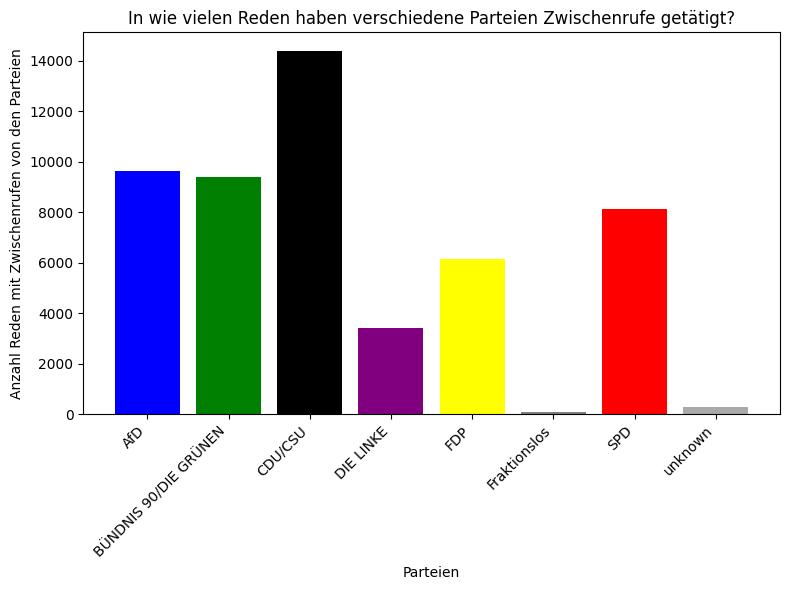

In [23]:
#Graph

# Custom colors for each party
colors = ['blue', 'green', 'black', 'purple', 'yellow', 'grey', 'red', 'darkgrey']


# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(uniqueparties, Kommentarepropartei, color=colors[:len(uniqueparties)])

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45, ha="right")

# Add labels and title
plt.xlabel('Parteien')
plt.ylabel('Anzahl Reden mit Zwischenrufen von den Parteien')
plt.title('In wie vielen Reden haben verschiedene Parteien Zwischenrufe getätigt?')

# Show the plot
plt.tight_layout()
plt.show()

In [24]:
#Anzahl Reden pro Partei
Redenpropartei = {}

for entry in speeches:
    partei = entry["party"]
    if partei in Redenpropartei:
        Redenpropartei[partei] += 1
    else: Redenpropartei[partei] = 1

for partei, count in Redenpropartei.items():
    print(partei, count)

BÜNDNIS 90/DIE GRÜNEN 3331
CDU/CSU 4304
Fraktionslos 113
AfD 2534
SPD 4363
FDP 2665
unknown 699
DIE LINKE 1534


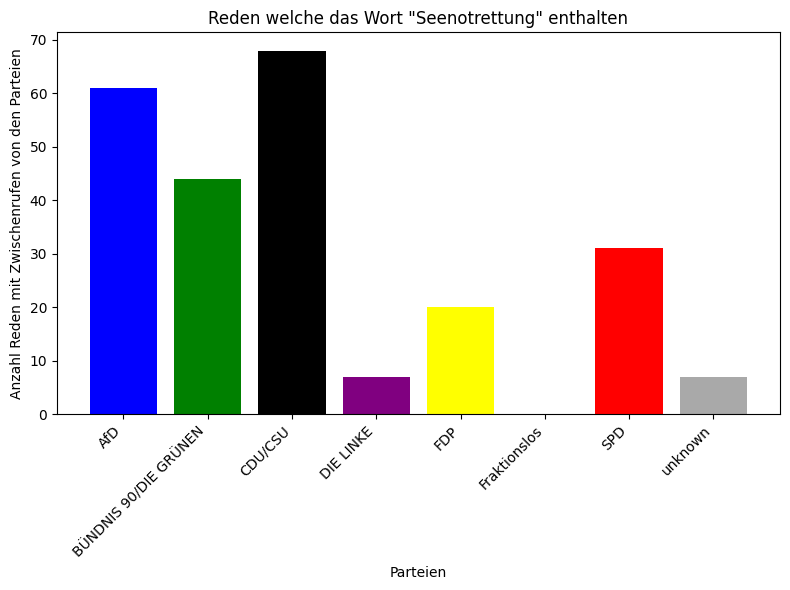

In [25]:
#Filtere Reden nach suchwort und zeige in wie vielen Reden die Parteien Zwischenrufe getätigt haben

Suchwort = "Seenotrettung"

#Folgende Suchworte führen zu besonders deutlichen Ergebnissen: ideologisch, Verfassungsfeind, 16 Jahre, Vogelschiss

Redenmitsuchwort = [ rede for rede in speeches if Suchwort in rede['text']]

party_mention_matrix = np.zeros((len(uniqueparties), len(uniqueparties)), dtype=int)#row,column

# Create mappings for names to party and party to index
name_to_party = {node["name"]: node["party"] for node in nodelist}
party_to_index = {party: i for i, party in enumerate(uniqueparties)}

# Regular expression to match content inside curly brackets
curly_brackets_pattern = r"\{\(.*?\)\}"

# Populate the party-to-party mention matrix
for speech in Redenmitsuchwort:#"Redenmitsuchwort" mit "speeches" ersetzen um Verteilung über alle Reden zu sehen
    speaker_name = speech["name"]
    speaker_party = name_to_party[speaker_name]

    # Find all text inside curly brackets in the speech
    inside_curly_brackets = re.findall(curly_brackets_pattern, speech["text"])

    # Join all text found inside curly brackets into a single string for easier name search
    inside_text = " ".join(inside_curly_brackets)

    # Check mentions inside curly brackets
    for mentioned_name in name_to_party.keys():
        if mentioned_name != speaker_name and mentioned_name in inside_text:
            mentioned_party = name_to_party[mentioned_name]
            # Increment the party-to-party mention count
            speaker_index = party_to_index[speaker_party]
            mentioned_index = party_to_index[mentioned_party]
            party_mention_matrix[speaker_index][mentioned_index] += 1

Kommentarepropartei = np.sum(party_mention_matrix, axis=0)#Summe über Spalten, axis=1 würde anzeigen wie viele Kommentare es in Reden von der Partei gab

# Custom colors for each party
colors = ['blue', 'green', 'black', 'purple', 'yellow', 'grey', 'red', 'darkgrey']


# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(uniqueparties, Kommentarepropartei, color=colors[:len(uniqueparties)])

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45, ha="right")

# Add labels and title
plt.xlabel('Parteien')
plt.ylabel('Anzahl Reden mit Zwischenrufen von den Parteien')
plt.title(f'Reden welche das Wort "{Suchwort}" enthalten')

# Show the plot
plt.tight_layout()
plt.show()

In [26]:
#Matrix auf Ebene Regierung/Opposition
Regierung = [d["Regierung/Opposition"] for d in nodelist]
uniqueregierung = list(set(Regierung))
uniqueregierung.sort

regierung_mention_matrix = np.zeros((len(uniqueregierung), len(uniqueregierung)), dtype=int)#row,column

# Create mappings for names to party and party to index
name_to_regierung = {node["name"]: node["Regierung/Opposition"] for node in nodelist}
regierung_to_index = {party: i for i, party in enumerate(uniqueregierung)}

# Regular expression to match content inside curly brackets
curly_brackets_pattern = r"\{\(.*?\)\}"

# Populate the party-to-party mention matrix
for speech in speeches:
    speaker_name = speech["name"]
    speaker_regierung = name_to_regierung[speaker_name]

    # Find all text inside curly brackets in the speech
    inside_curly_brackets = re.findall(curly_brackets_pattern, speech["text"])

    # Join all text found inside curly brackets into a single string for easier name search
    inside_text = " ".join(inside_curly_brackets)

    # Check mentions inside curly brackets
    for mentioned_name in name_to_regierung.keys():
        if mentioned_name != speaker_name and mentioned_name in inside_text:
            mentioned_regierung = name_to_regierung[mentioned_name]
            # Increment the party-to-party mention count
            speaker_index = regierung_to_index[speaker_regierung]
            mentioned_index = regierung_to_index[mentioned_regierung]
            regierung_mention_matrix[speaker_index][mentioned_index] += 1

# Print the matrix and parties
print("Regierung/Opposition:", uniqueregierung)
print("Regierung/Opposition matrix:")
print(regierung_mention_matrix)
#Interpretation: Regierungspolitiker haben in 15635 Reden von Oppositionspoltikern kommentiert

Regierung/Opposition: ['Opposition', 'unk', 'Regierung']
Regierung/Opposition matrix:
[[ 8670   137 15635]
 [  637    12   347]
 [18202   126  7658]]


In [27]:
#unknown entfernen
unk_index = regierung_to_index["unk"]

regierung_mention_matrix1 = np.delete(regierung_mention_matrix, unk_index, axis=0)  
regierung_mention_matrix2 = np.delete(regierung_mention_matrix1, unk_index, axis=1)  


uniqueregierung2 = [entry for entry in uniqueregierung if entry != "unk"]

# Print the updated matrix
print("Updated Matrix:")
print(regierung_mention_matrix2)
print(uniqueregierung2)

# Convert the matrix to a pandas DataFrame and set row/column labels with new_names
#dfregierung = pd.DataFrame(regierung_mention_matrix2, index=uniqueregierung2, columns=uniqueregierung2)

# Export the DataFrame to an Excel file
#output_file = 'RegierungOpposition.xlsx'
#dfregierung.to_excel(output_file)

Updated Matrix:
[[ 8670 15635]
 [18202  7658]]
['Opposition', 'Regierung']
